In [31]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/per

# Importing the libraries

In [32]:
!pip install gradio

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
import gradio

# Reshaping images to preferred size

In [34]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_traindata(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) 
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

# Loading the Dataset

In [35]:
train = get_traindata('../input/chest-xray-pneumonia/chest_xray/chest_xray/train')
test = get_traindata('../input/chest-xray-pneumonia/chest_xray/chest_xray/test')
val = get_traindata('../input/chest-xray-pneumonia/chest_xray/chest_xray/val')

OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



/tmp/ipykernel_32/3067414830.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



# Data Visualization & Preprocessing

In [36]:

# # Convert training and testing data to a DataFrame
# train_df = pd.DataFrame(train, columns=['Image', 'Label'])



# # Map the numeric labels to categorical labels
# train_df['Label'] = train_df['Label'].map({0: 'Pneumonia', 1: 'Normal'})



# # Visualize the count of each category using Seaborn
# sns.set_style('darkgrid')
# sns.countplot(data=train_df, x='Label',palette=["red", "green"])
# plt.title("Total cases in training dataset")
# plt.show()




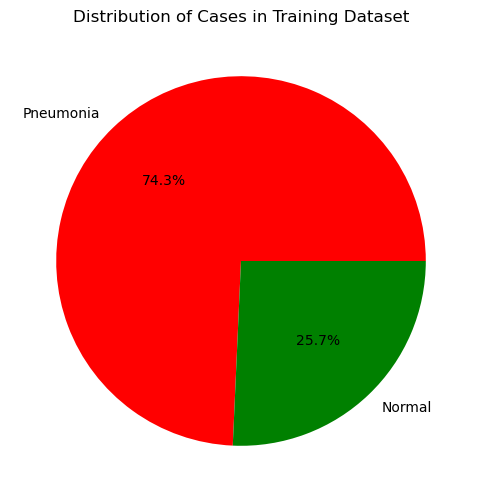

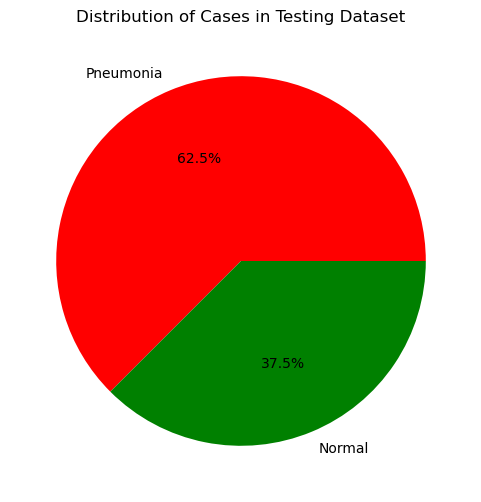

In [37]:
#  Convert training and testing data to a DataFrame and Mapping the numeric labels to categorical labels

train_df = pd.DataFrame(train, columns=['Image', 'Label'])
train_df['Label'] = train_df['Label'].map({0: 'Pneumonia', 1: 'Normal'})
train_category_counts = train_df['Label'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(train_category_counts, labels=train_category_counts.index, autopct='%1.1f%%', colors=['red', 'green'])
plt.title("Distribution of Cases in Training Dataset")
plt.show()

test_df = pd.DataFrame(test, columns=['Image', 'Label'])
test_df['Label'] = test_df['Label'].map({0: 'Pneumonia', 1: 'Normal'})
test_category_counts = test_df['Label'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(test_category_counts, labels=test_category_counts.index, autopct='%1.1f%%', colors=['red', 'green'])
plt.title("Distribution of Cases in Testing Dataset")
plt.show()




**Scaling the chest X-ray**

Text(0.5, 1.0, 'NORMAL')

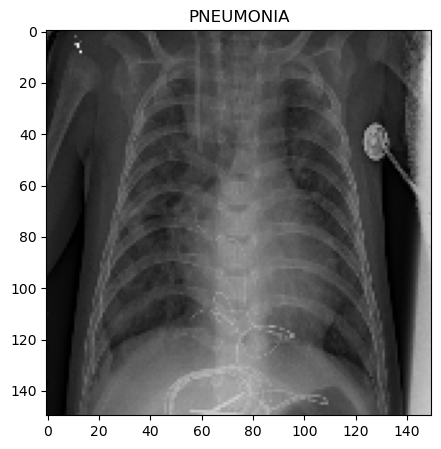

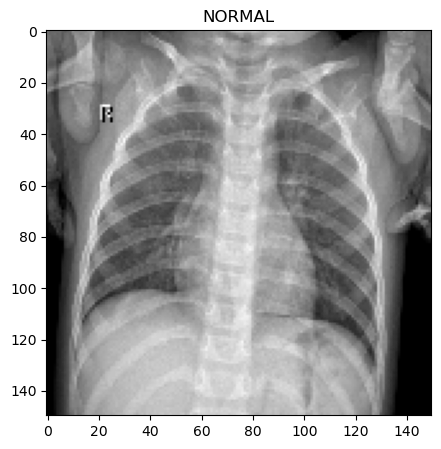

In [38]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

# Extracting features and labels from the input data

In [39]:
x_train_data = []
y_train_labels = []

x_test_data = []
y_test_labels = []

x_validation_data = []
y_validation_labels = []

for feature, label in train:
    x_train_data.append(feature)
    y_train_labels.append(label)

for feature, label in test:
    x_test_data.append(feature)
    y_test_labels.append(label)
    
for feature, label in val:
    x_validation_data.append(feature)
    y_validation_labels.append(label)


# Performing Greyscale Normalization. 

**Grayscale normalization is applied to mitigate the impact of variations in illumination. Additionally, CNN models tend to converge more quickly when working with data scaled to the [0, 1] range rather than the original [0, 255] range**

In [40]:
positives=[]
negatives=[]
for i in range(len(y_train_labels)):
    if y_train_labels[i]:
        positives.append(x_train_data[i])
    else:
        negatives.append(x_train_data[i])

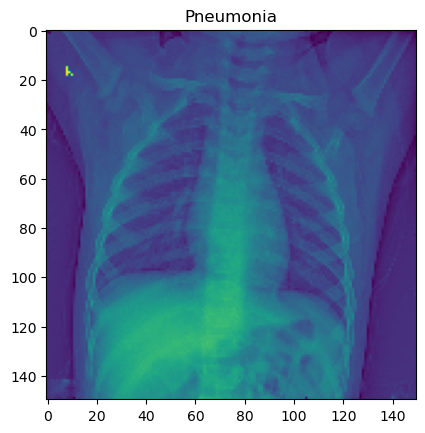

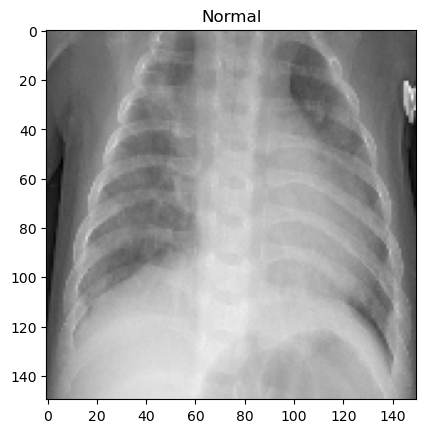

In [41]:
plt.imshow(positives[0])
plt.title("Pneumonia")
plt.show()

plt.imshow(negatives[4],cmap="gray")
plt.title("Normal")
plt.show()

In [42]:
# Normalize the data
x_train_data = np.array(x_train_data) / 255
x_validation_data = np.array(x_validation_data) / 255
x_test_data = np.array(x_test_data) / 255

In [43]:
# resize data for deep learning 
x_train_data = x_train_data.reshape(-1, img_size, img_size, 1)
y_train_labels = np.array(y_train_labels)

x_validation_data = x_validation_data.reshape(-1, img_size, img_size, 1)
y_validation_labels = np.array(y_validation_labels)

x_test_data = x_test_data.reshape(-1, img_size, img_size, 1)
y_test_labels = np.array(y_test_labels)

# DATA AUGMENTATION

**To mitigate the challenges posed by overfitting, one effective strategy involves expanding the training dataset artificially. This entails introducing modifications to the existing data through minor transformations, aiming to replicate inherent variations.**

**The concept revolves around employing data augmentation techniques, which involve modifying training data in manners that alter the array representation while preserving the original label. These techniques have gained popularity due to their ability to diversify the dataset. Common augmentations encompass actions like converting images to grayscale, flipping them horizontally or vertically, randomly cropping sections, introducing color variations, adjusting translations, rotations, and more.**

In [44]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train_data)

# Model Training

In [45]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , 
                 input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))

model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))

model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))

model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 150, 150, 32)      320       
                                                                 
 batch_normalization_5 (Batc  (None, 150, 150, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout_4 (Dropout)         (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_6 (Batc  (None, 75, 75, 64)      

In [46]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience = 2, 
                                            verbose=1,
                                            factor=0.3, 
                                            min_lr=0.000001)

In [59]:
history = model.fit(datagen.flow(x_train_data,y_train_labels, batch_size = 32) ,
                    epochs = 10, 
                    validation_data = datagen.flow(x_validation_data, y_validation_labels) ,
                    callbacks = [learning_rate_reduction])

Epoch 1/10
163/163 [==============================] - 191s 1s/step - loss: 0.0819 - accuracy: 0.9745 - val_loss: 0.7452 - val_accuracy: 0.6875 - lr: 1.0000e-06
Epoch 2/10
163/163 [==============================] - 191s 1s/step - loss: 0.0791 - accuracy: 0.9699 - val_loss: 1.0831 - val_accuracy: 0.6250 - lr: 1.0000e-06
Epoch 3/10
163/163 [==============================] - 191s 1s/step - loss: 0.0909 - accuracy: 0.9684 - val_loss: 1.3622 - val_accuracy: 0.5625 - lr: 1.0000e-06
Epoch 4/10
163/163 [==============================] - 191s 1s/step - loss: 0.0831 - accuracy: 0.9714 - val_loss: 1.4483 - val_accuracy: 0.6875 - lr: 1.0000e-06
Epoch 5/10
163/163 [==============================] - 192s 1s/step - loss: 0.0820 - accuracy: 0.9703 - val_loss: 1.4076 - val_accuracy: 0.6250 - lr: 1.0000e-06
Epoch 6/10
163/163 [==============================] - 192s 1s/step - loss: 0.0799 - accuracy: 0.9737 - val_loss: 0.7678 - val_accuracy: 0.7500 - lr: 1.0000e-06
Epoch 7/10
163/163 [====================

In [60]:
print("Loss of the model is - " , model.evaluate(x_test_data,y_test_labels)[0])
print("Accuracy of the model is - " , model.evaluate(x_test_data,y_test_labels)[1]*100 , "%")

20/20 [==============================] - 5s 260ms/step - loss: 0.3325 - accuracy: 0.9038
Loss of the model is -  0.3324856758117676
20/20 [==============================] - 5s 256ms/step - loss: 0.3325 - accuracy: 0.9038
Accuracy of the model is -  90.38461446762085 %


# Analysis after Model Training

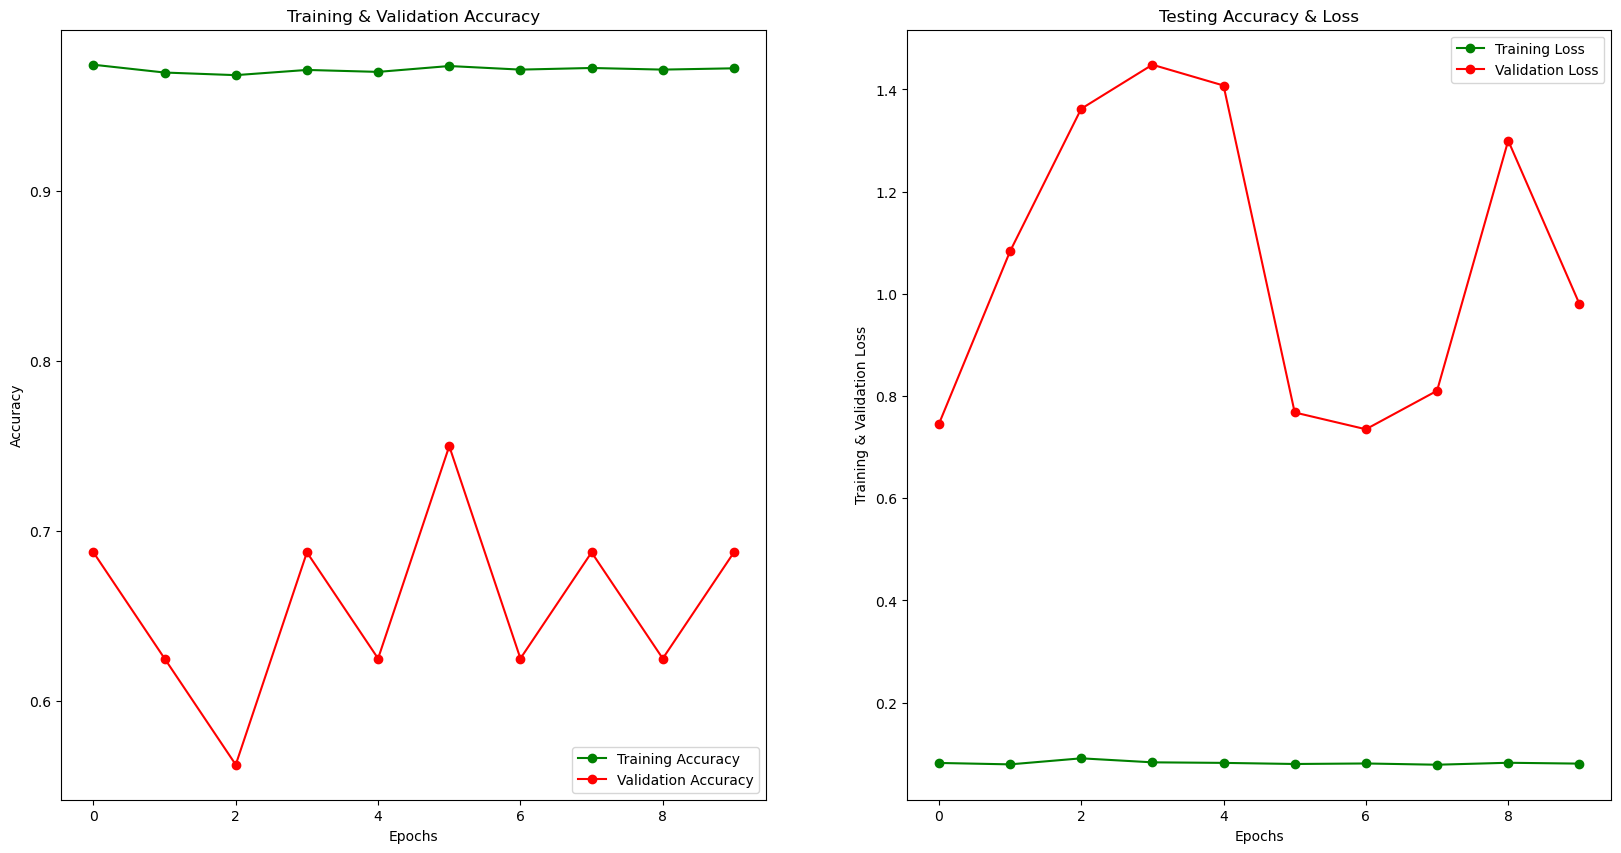

In [61]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [50]:
predictions = model.predict(x_test_data)
for i in range(len(predictions)):
    predictions[i] = 1 if predictions[i]>0.5 else 0

20/20 [==============================] - 5s 253ms/step


In [62]:
print(classification_report(y_test_labels, 
                            predictions, 
                            target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.93      0.91      0.92       390
   Normal (Class 1)       0.86      0.89      0.87       234

           accuracy                           0.90       624
          macro avg       0.90      0.90      0.90       624
       weighted avg       0.90      0.90      0.90       624



# CONFUSION MATRIX

In [52]:
conf_mat = confusion_matrix(y_test_labels,predictions)
conf_mat = pd.DataFrame(conf_mat , index = ['0','1'] , columns = ['0','1'])
conf_mat

,0,1
0,356,34
1,26,208


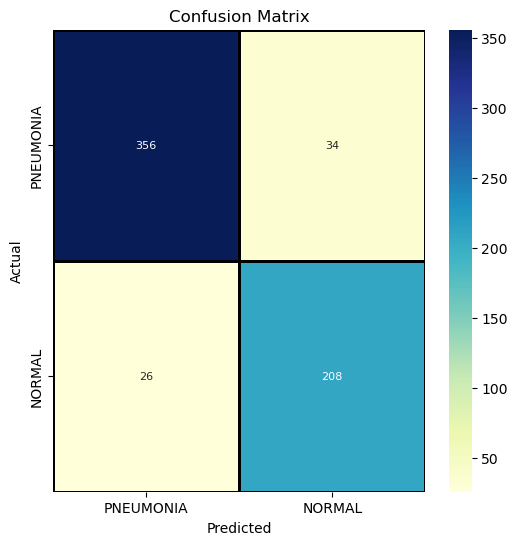

In [53]:
plt.figure(figsize=(6, 6))  
sns.heatmap(conf_mat, cmap="YlGnBu", linecolor='black', 
            linewidth=1, annot=True, fmt='', xticklabels=labels, 
            yticklabels=labels,
            annot_kws={"size": 8})  
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# Predicting the disease using Gradio

In [54]:
def pneumoniaPrediction(img):
    img=np.array(img)/255
    img=img.reshape(-1,150,150,1)
    isPneumonic = model.predict(img)[0]
    imgClass="Normal" if isPneumonic<0.5 else "Pneumonic"
    return imgClass

In [55]:
pr=model.predict(x_test_data)
for i in range(len(pr)):
    if pr[i]>0.5:
        pr[i]=1
    else:
        pr[i]=0

20/20 [==============================] - 5s 253ms/step


In [56]:
img=gradio.inputs.Image(shape=(150,150))
label=gradio.outputs.Label(num_top_classes=1)

/tmp/ipykernel_32/32109986.py:1: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  img=gradio.inputs.Image(shape=(150,150))
/tmp/ipykernel_32/32109986.py:1: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  img=gradio.inputs.Image(shape=(150,150))
/tmp/ipykernel_32/32109986.py:2: GradioDeprecationWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  label=gradio.outputs.Label(num_top_classes=1)
/tmp/ipykernel_32/32109986.py:2: GradioUnusedKwargWarning: You have unused kwarg parameters in Label, please remove them: {'type': 'auto'}
  label=gradio.outputs.Label(num_top_classes=1)


In [57]:
interface=gradio.Interface(fn= pneumoniaPrediction,
                          title="Pneumonia Detection using Chest X-ray",
                          inputs= img,
                          outputs=label,
                          interpretation="default")
interface.launch(debug=True, share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://8cd0d6714a971e147c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 80ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://8cd0d6714a971e147c.gradio.live
